# Transient Analysis of a Geometrically Nonlinear Frame

[![Commits since latest release][gh-image]][gh-link]

[gh-link]: https://github.com/claudioperez/elle-0002/compare/v0.0.0...master
[gh-image]: https://img.shields.io/github/commits-since/claudioperez/elle-0002/v0.0.0?style=social

In [1]:
import anon.conf
anon.conf.config.update('jax_disable_jit', True)
anon.conf.config.update('jax_enable_x64', True)
import anabel
import anon
import jax
import anon.atom as anp
import elle.sections
import elle.beam2d
import elle.springs
import anabel as em
mat = elle.springs.isokin.no1(3600.0,4.0,H0=36.0)
# mat = elle.springs.gmp.no5(60.0,29e3)
GirderSec = anabel.sections.Tee
ColumnSec = anabel.sections.Rectangle
geom_template = elle.beam2d.transform_no2(elle.beam2d.geom_no2)
beam_template = elle.beam2d.resp_no6

An `Assembler` is an object with an `.assemble()` and optionally a `.compose()` method.

In [2]:
# Create a model Assembler
model = em.SkeletalModel(ndm=2,ndf=3)

# Define problem parameters
P1 = model.param("P1")

# Define model components
girder_section = GirderSec(d=24.0, bf=60.0, tf=6.0, tw=18.0, mat=mat).assemble()
column_section = ColumnSec(d=30.0, b=30.0,mat=mat).assemble()
basic_girder  = beam_template(*[girder_section]*4, quad={"n": 4, "rule": "lobatto"})
# basic_column  = beam_template(*[column_section]*8, quad={"n": 4, "rule": "mid"})
basic_column = elle.beam2d.resp_no1(A=30.0**2,E=3600.0,I=30**4/12)

girder = geom_template(basic_girder)
column = geom_template(basic_column)

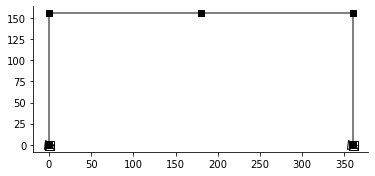

In [3]:
# Set up nodes
ft = 12.
B, H = 30.*ft, 13.*ft
model.node("1",  0.,  0.)
model.node("2",  0.,  H )
model.node("3", B/2,  H )
model.node("4",  B ,  H )
model.node("5",  B ,  0.)

model.beam("a", "1", "2", elem=column)
model.beam("b", "2", "3", elem=girder)
model.beam("c", "3", "4", elem=girder)
model.beam("d", "4", "5", elem=column)

model.boun("1", [1,1,1])
model.boun("5", [1,1,1])

model.load("2", P1, dof="x")
model.load("2", -2.0, dof="y")
model.load("2", -2.0, dof="y")

em.plot_skeletal(model);

In [4]:
model.dofs

[[9, 10, 11], [0, 1, 2], [3, 4, 5], [6, 7, 8], [12, 13, 14]]

In [5]:
f = model.compose()

In [6]:
f(1000)

/home/claudio/elle/numeric/elle/numeric/inverse.py:109: UserWarning: Function inversion failed to converge.
  warnings.warn("Function inversion failed to converge.")


DeviceArray([[ 1.70610291],
             [ 0.02331842],
             [-0.01326677],
             [ 1.67563829],
             [-0.0466029 ],
             [ 0.00541659],
             [ 1.61815267],
             [ 0.01151919],
             [-0.01267151]], dtype=float64)

In [7]:
# for i in range(3):embler objects.

An assembler is typically characterized by collections of nodes, elements and parameters. The purpose of the assembler is to provide a convenient interface for interacting with and managing these entities.


#     fig, ax = em.plot_displ(model, f(10.*i),scale=1e2)

In [8]:
model.cycle(0,0,1000,5,5,1)
model.build_load_path(0)

DeviceArray([[    0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ],
             [    0.        ,   266.66666667,   533.33333333,
                800.        ,  1000.        ,   733.33333333,
                466.66666667,   200.        ,    -0.        ,
               -266.66666667,  -533.33333333,  -800.        ,
              -1000.        ,  -733.33333333,  -466.66666667,
               -200.        ,     0.        ,   266.66666667,
                533.33333333,   800.        ],
             [    0.        ,     0.        ,     0.        ,
                  0.        ,     0.        ,     0.        ,
                  0.        ,     0.  

In [9]:
df = anon.diff.jacfwd(f, None, (0,1), squeeze=False)